In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torchvision    # sudo -H pip3 install torchvision
import torchvision.transforms as transforms

In [3]:
from ipywidgets import interact, interact_manual, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

# Red convolucional

![ConvNet](figuras/CNN.png "ConvNet")
Imagen de [Introduction to Deep Learning: What Are Convolutional Neural Networks?](https://www.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html)

Para una exposición en detalle revisar [Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)

## Datos
Utilizaremos el conjunto de datos [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
Es necesario descargarlos dentro de una carpeta 'datos', dejar ahí el archivo comprimido para la sección siguiente y descomprimirlo para analizar su estructura en esta sección.

Cifar contiene **60,000** imágenes de $32 \times 32$ pixeles, para 10 clases de objetos.
$50,000$ son para entrenamiento y $10,000$ para pruebas (este último se puede subdividir cuando sea necesario contar con un conjunto de validación y otro de prueba).


### Utilizando torchvision

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [20]:
pwd

'/media/blackzafiro/blackzafiro/Documentos/ia-generativa/Programas'

In [21]:
BASE = _
print(BASE)

/media/blackzafiro/blackzafiro/Documentos/ia-generativa/Programas


In [22]:
data_batch_root = BASE + '/datos/cifar-10-python/cifar-10-batches-py/data_batch_'

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [24]:
try:
    # Carga localmente
    trainset = torchvision.datasets.CIFAR10(root=BASE + '/data', train=True,
                                            download=False, transform=transform)
except RuntimeError:
    # Descarga
    trainset = torchvision.datasets.CIFAR10(root=BASE + '/data', train=True,
                                            download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=BASE + '/data', train=False,
                                           download=False, transform=transform)

In [25]:
classes = tuple(trainset.classes)
classes

('airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [26]:
@interact(
    índice = (0, len(trainset.data) - 1)
)
def muestraImagenEntrenamiento(índice):
    data = trainset.data[índice]
    label = trainset.targets[índice]
    plt.figure(figsize = (2,2))
    plt.imshow(data)
    plt.title(classes[label])

interactive(children=(IntSlider(value=24999, description='índice', max=49999), Output()), _dom_classes=('widge…

### Creación de lotes

In [27]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [28]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [29]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [30]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 ship  frog  deer  frog


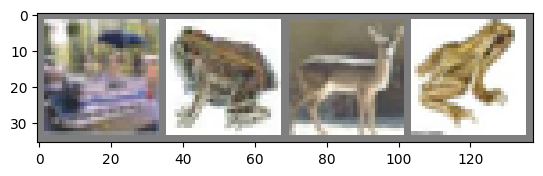

In [31]:
# show images
imshow(torchvision.utils.make_grid(images))

In [32]:
print(images[0])

tensor([[[ 0.6706,  0.8353,  0.8980,  ...,  0.4588,  0.4353,  0.5294],
         [ 0.1294,  0.5137,  0.8039,  ...,  0.3647,  0.3255,  0.2784],
         [-0.2549,  0.0431,  0.5137,  ...,  0.2941,  0.2392,  0.1451],
         ...,
         [-0.3725, -0.4510, -0.5686,  ..., -0.3804, -0.4902, -0.2784],
         [-0.3569, -0.4353, -0.5529,  ..., -0.5294, -0.5922, -0.3569],
         [-0.0039, -0.0353, -0.0902,  ..., -0.0980, -0.1686, -0.0431]],

        [[ 0.6784,  0.8118,  0.8510,  ...,  0.3882,  0.3961,  0.5529],
         [ 0.1451,  0.4980,  0.7569,  ...,  0.2706,  0.2863,  0.3255],
         [-0.2314,  0.0353,  0.4588,  ...,  0.1843,  0.2157,  0.2157],
         ...,
         [-0.3725, -0.4431, -0.5451,  ..., -0.4353, -0.4980, -0.2706],
         [-0.3490, -0.4196, -0.5294,  ..., -0.5373, -0.5608, -0.3020],
         [ 0.0118, -0.0196, -0.0667,  ..., -0.0588, -0.0980,  0.0353]],

        [[ 0.5922,  0.8353,  0.8824,  ...,  0.3412,  0.3490,  0.4745],
         [ 0.0353,  0.4824,  0.7647,  ...,  0

## Convolución

Parámetros:

* *kernel size*: tamaño del filtro.
* *kernel tipe*: los valores del filtro, casos particulares son la identidad, detección de bordes, afinar, blur, etc.
* *strides* o *saltos*: distance recorrida entre aplicaciones sucesivas del núcleo.
* *padding*: técnica para agregar datos a las orillas de la imagen.
* *output layers*: número de núcleos distintos que serán aplicados a la imagen.

* input: [batch, in_height, in_width, in_channels]

[PyTorchConvolucion](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

Una capa convolucional puede incluir varios filtros aplicados sobre una imagen a color (3 canales: RGB) y devolver la concatenación de los resultados obtenidos al aplicar cada filtro (Gif de [An intuitive guide to Convolutional Neural Networks](https://medium.freecodecamp.org/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050), original en [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)).

Para reducir el tamaño de las imágenes, se puede utilizar la operación **Max pooling** [Convolutional Neural Nets in Pytorch](https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/)

In [33]:
from torch.utils.data.sampler import SubsetRandomSampler

# Entrenamiento
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

# Validación
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

# Prueba
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [34]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 16 *16)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

## Entrenamiento

In [35]:
import torch.optim as optim

def train(self):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    
setattr(SimpleCNN, 'train', train)

In [36]:
net = SimpleCNN()

In [ ]:
net.train()

## Prueba

GroundTruth:    cat  ship  ship airplane
Predicted:    dog  ship  ship  ship


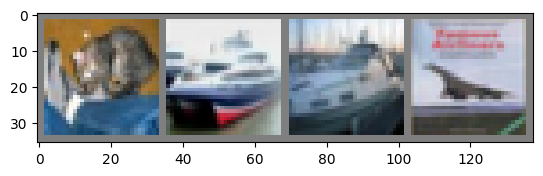

In [28]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [29]:
# Dataset completo

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 59 %


In [30]:
# Clase por clase

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of airplane : 66 %
Accuracy of automobile : 68 %
Accuracy of  bird : 49 %
Accuracy of   cat : 31 %
Accuracy of  deer : 41 %
Accuracy of   dog : 53 %
Accuracy of  frog : 70 %
Accuracy of horse : 69 %
Accuracy of  ship : 84 %
Accuracy of truck : 63 %
